# Part B

## Step 1 - Adding Features

#### Load Data

In [1]:
import pandas as pd

hotels_file_path = "./hotels_data.csv"  
df = pd.read_csv(hotels_file_path)

df.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4


#### Add columns and load to new CSV

In [2]:
#Ensure dates are in correct format
df['Snapshot Date'] = pd.to_datetime(df['Snapshot Date'])
df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])

df['DayDiff'] = (df['Checkin Date'] - df['Snapshot Date']).dt.days
df['WeekDay'] = df['Checkin Date'].dt.day_name()
df['DiscountDiff'] = df['Original Price'] - df['Discount Price']
df['DiscountPerc'] = (df['DiscountDiff'] / df['Original Price']) * 100

print(df.head())

   Snapshot ID Snapshot Date Checkin Date  Days  Original Price  \
0            1    2015-07-17   2015-08-12     5            1178   
1            1    2015-07-17   2015-08-19     5            1113   
2            1    2015-07-17   2015-08-13     5            4370   
3            1    2015-07-17   2015-07-26     5            1739   
4            1    2015-07-17   2015-08-12     5            1739   

   Discount Price  Discount Code  Available Rooms  \
0            1040              1                6   
1             982              1                8   
2            4240              1                3   
3            1667              1               18   
4            1672              1                3   

                               Hotel Name  Hotel Stars  DayDiff    WeekDay  \
0  Best Western Plus Seaport Inn Downtown            3       26  Wednesday   
1  Best Western Plus Seaport Inn Downtown            3       33  Wednesday   
2                  The Peninsula New York   


**New csv format**

| Column Name       | Description                                                                                         | Example Value                       |
|--------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------|
| **Snapshot ID**    | Unique identifier for each snapshot of data                                                        | 1                                   |
| **Snapshot Date**  | The date when the snapshot was taken                                                               | 2015-07-17                          |
| **Checkin Date**   | The date of check-in for the hotel                                                                 | 2015-08-12                          |
| **Days**           | Duration of the stay in days                                                                       | 5                                   |
| **Original Price** | Price of the stay without any discount (in dollars)                                                | 1178                                |
| **Discount Price** | Price of the stay after applying the discount (in dollars)                                         | 1040                                |
| **Discount Code**  | Code representing the type of discount applied (values 1-4, with 1 indicating no discount possible) | 1                                   |
| **Available Rooms**| Number of rooms available at the specified check-in date                                           | 6                                   |
| **Hotel Name**     | Name of the hotel                                                                                  | Best Western Plus Seaport Inn Downtown |
| **Hotel Stars**    | Star rating of the hotel                                                                           | 3                                   |
| **DayDiff**        | Number of days between the Snapshot Date and Checkin Date                                          | 26                                  |
| **WeekDay**        | Day of the week corresponding to the Checkin Date                                                  | Wednesday                           |
| **DiscountDiff**   | Difference between the Original Price and Discount Price (in dollars)                              | 138                                 |
| **DiscountPerc**   | Percentage of discount applied, calculated as `(DiscountDiff / Original Price) * 100`             | 11.714770797962649                           |


#### Save To CSV

In [3]:
changed_hotels_path = "./hotels_data_changed.csv"
df.to_csv(changed_hotels_path, index=False)

## Step 2 - Best Discount Code


**b. Classification Algorithms:** 
   - After creating this dataset, we will implement various classification algorithms in Python to predict the maximum discount code given the input parameters. 
   - Implement and evaluate the following five algorithms: Random Forest, Decision Tree, Naïve Bayes, XGBoost, and a simple Random classifier.
   - For each algorithm, you need to experiment with different parameter settings to find the optimal combination that yields the best performance. 
   - Explanation of how each chosen parameter affects the algorithm's performance. 

#### Data Preperation

In [4]:
# Drop irrelevant columns

df = pd.read_csv(changed_hotels_path) 
df = df[['WeekDay', 'Snapshot Date', 'Checkin Date', 'DayDiff', 'Hotel Name', 'Discount Code']] 
df = df.rename(columns={'Discount Code': 'Class'})
df.head()

,WeekDay,Snapshot Date,Checkin Date,DayDiff,Hotel Name,Class
0,Wednesday,2015-07-17,2015-08-12,26,Best Western Plus Seaport Inn Downtown,1
1,Wednesday,2015-07-17,2015-08-19,33,Best Western Plus Seaport Inn Downtown,1
2,Thursday,2015-07-17,2015-08-13,27,The Peninsula New York,1
3,Sunday,2015-07-17,2015-07-26,9,Eventi Hotel a Kimpton Hotel,1
4,Wednesday,2015-07-17,2015-08-12,26,Eventi Hotel a Kimpton Hotel,1


In [5]:
# Feature Engineering

def map_days_to_numbers(df: pd.DataFrame) -> pd.DataFrame:
    weekday_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}
    df['WeekDay'] = df['WeekDay'].map(weekday_mapping)
    return df

def map_hotel_names_to_numbers(df: pd.DataFrame) -> pd.DataFrame:
    hotel_mapping = {hotel: i for i, hotel in enumerate(df['Hotel Name'].unique())}
    df['Hotel_Index'] = df['Hotel Name'].map(hotel_mapping)
    df.drop(['Hotel Name'], axis=1, inplace=True)
    return df

def map_date_to_numbers(df: pd.DataFrame, old_coloumn: str, new_coloumn: str) -> pd.DataFrame:
    df[old_coloumn] = pd.to_datetime(df[old_coloumn])
    df[f'{new_coloumn}_Year'] = df[old_coloumn].dt.year
    df[f'{new_coloumn}_Month'] = df[old_coloumn].dt.month
    df[f'{new_coloumn}_Day'] = df[old_coloumn].dt.day
    df.drop([old_coloumn], axis=1, inplace=True)

    return df

In [6]:
df = map_days_to_numbers(df)
df = map_hotel_names_to_numbers(df)
df = map_date_to_numbers(df, 'Snapshot Date', 'Snapshot')
df = map_date_to_numbers(df, 'Checkin Date', 'Checkin')
df.head()

,WeekDay,DayDiff,Class,Hotel_Index,Snapshot_Year,Snapshot_Month,Snapshot_Day,Checkin_Year,Checkin_Month,Checkin_Day
0,4,26,1,0,2015,7,17,2015,8,12
1,4,33,1,0,2015,7,17,2015,8,19
2,5,27,1,1,2015,7,17,2015,8,13
3,1,9,1,2,2015,7,17,2015,7,26
4,4,26,1,2,2015,7,17,2015,8,12


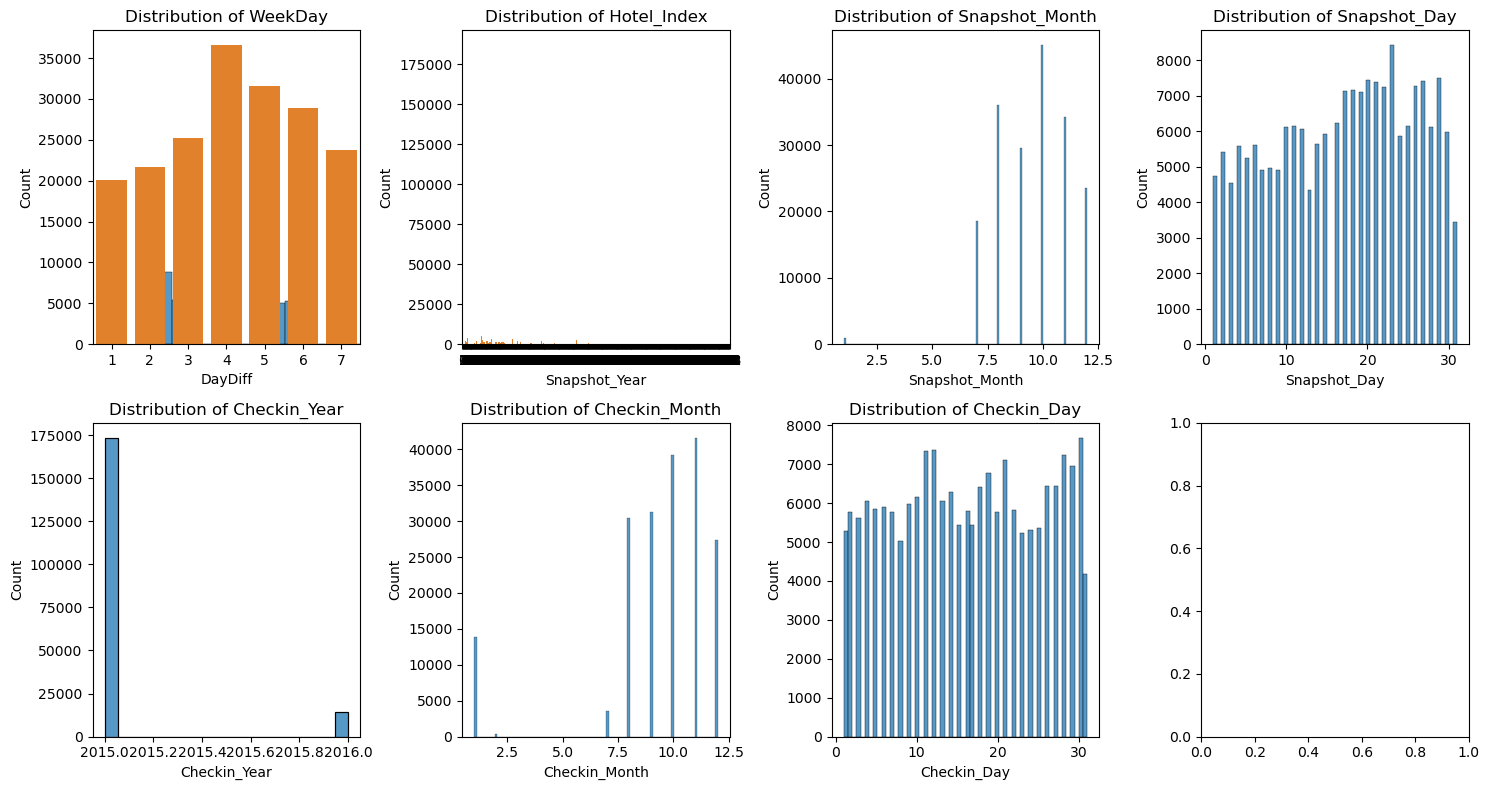

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['DayDiff', 'Snapshot_Year', 'Snapshot_Month', 'Snapshot_Day', 'Checkin_Year', 'Checkin_Month', 'Checkin_Day']
categorical_features = ['WeekDay', 'Hotel_Index']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flatten()

# Plot histograms for numerical features
for i, feature in enumerate(numerical_features):
  sns.histplot(data=df, x=feature, ax=axes[i])
  axes[i].set_title(f'Distribution of {feature}')

# Plot bar charts for categorical features (assuming enough data for each category)
for i, feature in enumerate(categorical_features):
  sns.countplot(data=df, x=feature, ax=axes[i])
  axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [8]:
# Train Test Split

from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df[['WeekDay', 'DayDiff', 'Hotel_Index', 'Snapshot_Year', 'Snapshot_Month', 'Snapshot_Day', 'Checkin_Year', 'Checkin_Month', 'Checkin_Day']]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#### Naive Bayes
We have the following feature types:

* **Continuous:**
    - `DayDiff` 
    - `Snapshot_Year`
    - `Snapshot_Month`
    - `Snapshot_Day`
    - `Checkin_Year`
    - `Checkin_Month`
    - `Checkin_Day`

* **Categorical:**
    - `WeekDay` 
    - `Hotel_Index`

**Naive Bayes Variants and Suitability:**

* **GaussianNB:**
    - **Best suited for continuous features.** It assumes that the features are normally distributed (Gaussian). Since we have several continuous features GaussianNB seems like the choice.

* **MultinomialNB:**
    - **Suitable for discrete features.** While `WeekDay` and `Hotel_Index` can be treated as categorical, they don't inherently represent counts or frequencies.

* **BernoulliNB:**
    - **Suitable for binary features.** Not applicable in this case as none of the features are binary.

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred)) 

Accuracy: 0.32
              precision    recall  f1-score   support

           1       0.20      0.07      0.11      7843
           2       0.34      0.59      0.43     11979
           3       0.30      0.39      0.34     11126
           4       0.00      0.00      0.00      6622

    accuracy                           0.32     37570
   macro avg       0.21      0.26      0.22     37570
weighted avg       0.24      0.32      0.26     37570



/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

## Step 3 - Clustering Based on Price Polices 


### Data Preparation  


Identify the 150 hotels with the most data in the dataset and extract their records.

In [201]:
import pandas as pd

file_path = "./hotels_data_changed.csv"  
df = pd.read_csv(file_path)

hotel_counts = df['Hotel Name'].value_counts()
top_150_hotels = hotel_counts.head(150).index
filtered_df = df[df['Hotel Name'].isin(top_150_hotels)]

filtered_df.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,Thursday,130,2.974828
3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,Sunday,72,4.140311
4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,67,3.852789
5,1,2015-07-17,2015-08-07,5,1436,1345,1,9,Grand Hyatt New York,4,21,Friday,91,6.337047
6,1,2015-07-17,2015-08-09,5,1616,1525,1,5,Grand Hyatt New York,4,23,Sunday,91,5.631188


Find the 40 most common check-in dates  in the dataset and extract their records.


In [202]:
checkin_counts = filtered_df['Checkin Date'].value_counts()
top_40_checkin_dates = checkin_counts.head(40).index
filtered_checkin_df = filtered_df[filtered_df['Checkin Date'].isin(top_40_checkin_dates)]

filtered_checkin_df.head()

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,Thursday,130,2.974828
4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,67,3.852789
7,1,2015-07-17,2015-08-12,5,1256,1183,1,5,Grand Hyatt New York,4,26,Wednesday,73,5.812102
8,1,2015-07-17,2015-08-13,5,1256,1201,1,54,Grand Hyatt New York,4,27,Thursday,55,4.378981
29,1,2015-07-17,2015-08-12,5,3763,3378,1,39,Park Hyatt New York,5,26,Wednesday,385,10.231199


**Task**

Build a 160-dimensional feature vector for each hotel based on its discount pricing behavior. Each vector is constructed by:
- Filtering the top 150 hotels (by record count) and the top 40 checkin dates.
- For each hotel, extracting 4 discount prices (one per discount code) for each of the 40 checkin dates.
- If no data is available for a specific (checkin date, discount code) combination, mark it with `-1`.

**Plan**

1. **Group the Data:**  
   Group the filtered data by **Hotel Name**, **Checkin Date**, and **Discount Code**. For each group, compute the minimum discount price, ensuring that only the best (lowest) price per combination is selected.

2. **Pivot to Wide Format:**  
   Transform the grouped data into a wide format where:
   - Each row represents a single hotel.
   - Each column represents a unique (Checkin Date, Discount Code) combination, totaling 160 columns (40 dates × 4 codes).

3. **Fill Missing Data:**  
   - Reindex the pivoted DataFrame so that every hotel has all 160 combinations, filling missing entries with `-1`.




In [203]:
# 1. Group by Hotel Name, Checkin Date, and Discount Code and select the minimum Discount Price.
grouped = (
    filtered_checkin_df
    .groupby(['Hotel Name', 'Checkin Date', 'Discount Code'])['Discount Price']
    .min()
    .reset_index()
)


# 2. Pivot the DataFrame so that:
#    - The index is 'Hotel Name'
#    - The columns are a MultiIndex with levels (Checkin Date, Discount Code)
#    - The values are the minimum discount prices.
pivot_df = grouped.pivot_table(index='Hotel Name',
                               columns=['Checkin Date', 'Discount Code'],
                               values='Discount Price')


# 3. Reindex the columns so that all 40 checkin dates and 4 discount codes are present.
#    Use the top_40_checkin_dates (from your earlier filtering) and the list [1, 2, 3, 4] for discount codes. 
all_combinations = pd.MultiIndex.from_product([top_40_checkin_dates, [1, 2, 3, 4]],
                                                names=['Checkin Date', 'Discount Code'])

pivot_df = pivot_df.reindex(columns=all_combinations, fill_value=-1)
pivot_df = pivot_df.fillna(-1)


pivot_df.columns = [
    col if isinstance(col, str) else f"{col[0]} - {col[1]}"
    for col in pivot_df.columns
]
pivot_df = pivot_df.reset_index()

print(pivot_df.head())
print(pivot_df.shape[0]) # Note we have 149 hotels instead of 150 - solution in next cell

                               Hotel Name  2015-11-11 - 1  2015-11-11 - 2  \
0                            Aloft Harlem            -1.0            -1.0   
1   Andaz 5th Avenue - a concept by Hyatt            -1.0          1982.0   
2  Andaz Wall Street - a concept by Hyatt          1078.0          1305.0   
3  Baccarat Hotel and Residences New York            -1.0            -1.0   
4                           Bentley Hotel            -1.0            -1.0   

   2015-11-11 - 3  2015-11-11 - 4  2015-10-14 - 1  2015-10-14 - 2  \
0            -1.0            -1.0          1381.0            -1.0   
1          2375.0            -1.0            -1.0          2435.0   
2          1430.0            -1.0          1625.0          1925.0   
3            -1.0            -1.0            -1.0            -1.0   
4            -1.0            -1.0            -1.0            -1.0   

   2015-10-14 - 3  2015-10-14 - 4  2015-11-04 - 1  ...  2015-11-03 - 3  \
0          1164.0            -1.0          1317.

**Verifying Missing Hotel Data**

After filtering and pivoting the data, we expect to have 150 hotels, but only 149 appear in our pivot table. This indicates that one (or more) of the top 150 hotels has no records for the top 40 check-in dates used in our analysis.

The code above does the following:
1. **Identify Missing Hotels:**  
   It compares the complete list of top 150 hotels (`top_150_hotels`) with the hotel names present in the pivoted DataFrame (`pivot_df`). Any hotel that is not present is added to the `missing_hotels` list.

2. **Check Data for Each Missing Hotel:**  
   For each missing hotel, it filters `filtered_checkin_df` (which already contains only records from the top 40 check-in dates) to see if there are any records for that hotel.  
   - If the resulting DataFrame is empty, it confirms that the hotel indeed has no data for those check-in dates.  
   - This explains why the hotel did not appear in the pivot table.

By verifying that the missing hotel has no records in the filtered data, we can conclude that the drop in the number of hotels is due to the absence of data for those check-in dates rather than an error in our processing pipeline.



In [204]:
# Assuming you have already defined:
# - top_150_hotels: the complete list of top 150 hotel names.
# - pivot_df: the pivoted DataFrame after grouping and filtering.
# - filtered_checkin_df: the DataFrame filtered by top 40 check-in dates.
#
# And the missing hotels are identified as:
missing_hotels = [hotel for hotel in top_150_hotels if hotel not in pivot_df['Hotel Name'].values]
print("Missing hotels:", missing_hotels)

# For each missing hotel, check if there is any record in the filtered_checkin_df.
for hotel in missing_hotels:
    hotel_records = filtered_checkin_df[filtered_checkin_df['Hotel Name'] == hotel]
    print(f"\nRecords for missing hotel '{hotel}':")
    print(hotel_records)  # This should print an empty DataFrame if no data is present.


Missing hotels: ['Embassy Suites Newark Airport']

Records for missing hotel 'Embassy Suites Newark Airport':
Empty DataFrame
Columns: [Snapshot ID, Snapshot Date, Checkin Date, Days, Original Price, Discount Price, Discount Code, Available Rooms, Hotel Name, Hotel Stars, DayDiff, WeekDay, DiscountDiff, DiscountPerc]
Index: []



**Task**

For each hotel, we have a 160-dimensional vector of discount prices (one for each combination of Checkin Date and Discount Code). The goal is to normalize these prices so that, for each hotel, the lowest valid discount price becomes 0 and the highest becomes 100. Any missing value (indicated by `-1`) should remain unchanged.

**Plan**

1. **Define a Normalization Function:**  
   Create a function (`normalize_row`) that:
   - Filters out the missing values (`-1`) from the row.
   - Computes the minimum and maximum values among the valid discount prices.
   - Applies the normalization formula:
     $$
     \text{normalized\_price} = \frac{(\text{price} - \text{min\_price})}{(\text{max\_price} - \text{min\_price})} \times 100
     $$
   - Handles the case where all valid prices are equal (to avoid division by zero) by setting them to 0.

2. **Apply the Function Row-wise:**  
   Normalize the discount prices for each hotel (i.e., for each row) by applying the function to all columns except the "Hotel Name".

3. **Round and Convert to Integers:**  
   After normalization, round the values to the nearest integer and convert them to an integer type, ensuring that the normalized prices are stored as integers.



In [205]:
def normalize_row(row):
    valid_mask = row != -1
    valid_prices = row[valid_mask]
    
    if valid_prices.empty:
        return row
    
    min_price = valid_prices.min()
    max_price = valid_prices.max()
    
   # Avoid division by zero if all valid prices are identical
    if min_price == max_price:
        row[valid_mask] = 0
    else:
        # Compute the normalized values, round them, and cast to int
        normalized_values = ((row[valid_mask] - min_price) / (max_price - min_price)) * 100
        row[valid_mask] = normalized_values.round(0).astype(int)
    
    return row


pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(normalize_row, axis=1)

for col in pivot_df.columns[1:]:
    pivot_df[col] = pd.to_numeric(pivot_df[col], errors='coerce')
    pivot_df[col] = pivot_df[col].astype("Int64")




print(pivot_df.head(5))



                               Hotel Name  2015-11-11 - 1  2015-11-11 - 2  \
0                            Aloft Harlem              -1              -1   
1   Andaz 5th Avenue - a concept by Hyatt              -1              40   
2  Andaz Wall Street - a concept by Hyatt               6              19   
3  Baccarat Hotel and Residences New York              -1              -1   
4                           Bentley Hotel              -1              -1   

   2015-11-11 - 3  2015-11-11 - 4  2015-10-14 - 1  2015-10-14 - 2  \
0              -1              -1              72              -1   
1              65              -1              -1              68   
2              26              -1              37              55   
3              -1              -1              -1              -1   
4              -1              -1              -1              -1   

   2015-10-14 - 3  2015-10-14 - 4  2015-11-04 - 1  ...  2015-11-03 - 3  \
0              32              -1              6

**Save to CSV**

In [206]:
hotels_clustering_data = "./hotels_clustering_data.csv"
pivot_df.to_csv(hotels_clustering_data, index=False)

### Hierarchical Clustering

**Task**

Using the normalized discount prices for each hotel, we will perform hierarchical clustering to group hotels that exhibit similar pricing behaviors. We have a 160-dimensional feature vector for each hotel (each dimension corresponds to a specific (Checkin Date, Discount Code) pair).

**Plan**

1. **Prepare the Data:**  
   - Load the saved CSV file (`hotels_clustering_data.csv`).
   - Separate the "Hotel Name" column (for labeling) from the numeric feature columns.

2. **Perform Hierarchical Clustering:**  
   - Use SciPy's `linkage` function with Ward's method (which works well with Euclidean distance) to compute the clustering.
   - Generate a linkage matrix that represents the hierarchical clustering.

3. **Plot the Dendrogram:**  
   - Use SciPy's `dendrogram` function to visualize the hierarchical clustering.
   - Label each leaf in the dendrogram with the corresponding hotel name to help interpret the clusters.


In [41]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 44.5 MB/s eta 0:00:00a 0:00:01


In [200]:
import pandas as pd
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage

def create_dendrogram_from_csv(csv_path, color_threshold=825, width=1200, height=1800):

    clu_df = pd.read_csv(csv_path)
    hotel_names = clu_df["Hotel Name"].values
    X = clu_df.drop("Hotel Name", axis=1).values
    Z = linkage(X, method='ward')

    fig = ff.create_dendrogram(
        X,
        orientation='left',
        labels=hotel_names,
        color_threshold=color_threshold,
        linkagefun=lambda x: Z
    )

    fig.update_layout(
        width=width,
        height=height
    )
    fig.show()
    
    return fig

color_threshold_list = [825, 750, 625, 500]
for color_threshold in color_threshold_list:
    print (f'color_threshold={color_threshold}')
    create_dendrogram_from_csv("hotels_clustering_data.csv", color_threshold=color_threshold)


color_threshold=825


color_threshold=750


color_threshold=625


color_threshold=500


### Results analysis

We performed hierarchical clustering on a dataset of hotels, where each hotel is represented by a **160-dimensional vector** of normalized discount prices. In simpler terms, each hotel’s vector shows *how* it discounts (and by how much) across different dates and discount codes. The dendrogram below clusters these hotels based on their similarity in discounting patterns.

Below, we examine **five different “cut” distances**—825, 750, 625, 500, and an additional view with fewer, broader clusters—and describe the cluster/subgroup formations you see in each figure.

---

#### Overall Explanation of the Dendrogram
- **X-axis**: The distance (or dissimilarity) at which clusters merge. Larger values mean more dissimilar groups.  
- **Y-axis**: The list of hotels, labeled along the left side.  
- **Colored Branches**: Each color indicates a cluster or subgroup under the specified distance threshold.

In general:  
- Hotels that **merge at smaller distances** (farther to the left in the dendrogram) are quite similar in how they price their discounts.  
- If you follow the dendrogram to the right until a major branch merges, that indicates hotels (or clusters of hotels) that are more dissimilar in their pricing behavior.

---

#### 1. Cut at Distance ≈ 825

![Cut at ~825](./images/clustering-825.png)  

- We see **three main clusters** forming at this high distance threshold.  
- **Group 1** (green), **Group 2** (red), and **Group 3** (blue) represent broad differences in discounting strategies. 
- Within each group, hotels share overall similarities in their discount patterns, but we’re not yet seeing the finer differences.

---

#### 2. Cut at Distance ≈ 750

![Cut at ~750](./images/clustering-750.png)  

- Lowering the threshold to **~750** begins to reveal **subgroups** within **Groups 1** and **3**, while **Group 2** remains mostly intact.  
- **Group 1** (previously green) starts splitting into multiple smaller clusters. These subgroups suggest that, while these hotels share a broad discount pattern, some differences in exact pricing behavior are now visible.  
- **Group 3** also subdivides more than before.
- **Group 2** is still one cluster, which indicates that these hotels are, as a whole, more cohesive or less varied in their discount strategies at this distance.

---

#### 3. Cut at Distance ≈ 625

![Cut at ~625](./images/clustering-625.png)  

- By **~625**, **Group 1** and **Group 3** break into several distinct subgroups, illustrating more granular differences.  
- **Group 2** is still a single cluster—indicating even at this more fine-grained level, the hotels in Group 2 remain very similar.  
- This suggests **Group 2** has a stable, uniform discount pattern, or at least they differ less from each other than from the other groups.

---

#### 4. Cut at Distance ≈ 500

![Cut at ~500](./images/clustering-500.png)  

- Finally, at **~500**, **Group 2** splits into **two subgroups**, showing that there are *at least* two distinct discounting patterns within Group 2 when we look closely.  
- **Groups 1 and 3** now fragment into many smaller subgroups. If you count them, there could be several mini-clusters in each.  
- Each **subgroup** here represents hotels that are very closely aligned in how they handle discounts across time—likely direct competitors or hotels following near-identical pricing guidelines.

---

#### Meaning of Subgroups

1. **Competitive Landscape**  
   - Hotels in the **same subgroup** are likely *direct competitors*, as they share nearly identical discount structures and timelines.

2. **Revenue Management Strategy**  
   - Subgroups often align with brand or chain policies (e.g., a single chain might appear as a tight cluster if they use centralized pricing software).  
   - The level of granularity around **500** distance reveals the *very fine details* of each hotel’s promotional activities.

3. **Marketing & Differentiation**  
   - If you manage a hotel in these clusters, you might examine how close neighbors in the dendrogram are discounting.  
   - Being in a tight cluster might motivate you to **differentiate** or **align** your pricing further.

4. **Insights for Group 2**  
   - Group 2’s stability up to a lower threshold (625) suggests a coherent pricing approach among its hotels. They only start splitting at ~500, which indicates that their differences are more subtle and only become apparent under a finer lens.

---

#### Putting It All Together
At **higher thresholds** (825+), we see broad strokes: *three main pricing behaviors*.  As we lower the cut distance, we discover **finer distinctions** within each major group:
- **Groups 1 & 3** develop several distinct subgroups earlier (around 750 or 625).  
- **Group 2** remains consistent longer and only splits around 500, revealing that even seemingly uniform clusters can exhibit small internal differences if you zoom in far enough.

In essence, **each subgroup** helps us understand small sets of hotels that might share very close discounting patterns—key information for competitive analysis and strategic pricing decisions.



### diving even deeper - (checking the hotel stars and average price with the pricing strategy)

The results from the last section were interesting, so i decided to run the same clustering but with the hotels stars, prices and discounts to see if some patterns emerge.

The new label now contains:
- stars
- avg price
- avg discount
- avg discount rate 

in this format:

`(stars) - price - discount - discount rate`

example:

(5) - 3898 - 3663 - 6% 

In [216]:
import pandas as pd

pivot_df = pd.read_csv("hotels_clustering_data.csv")
df = pd.read_csv("./hotels_data_changed.csv")

pivot_df["Hotel Name"] = pivot_df["Hotel Name"].astype(str).str.strip()
hotel_counts = df["Hotel Name"].value_counts()
top_150_hotels = hotel_counts.head(150).index

summary_df = (
    df[df["Hotel Name"].isin(top_150_hotels)]
    .groupby("Hotel Name")
    .agg({"Original Price": "mean", "Discount Price": "mean", "Hotel Stars": "first"})
    .reset_index()
)

summary_df["Hotel Name"] = summary_df["Hotel Name"].astype(str).str.strip()
summary_df["Original Price"] = summary_df["Original Price"].round(0).astype(int)
summary_df["Discount Price"] = summary_df["Discount Price"].round(0).astype(int)
merged_df = pivot_df.merge(summary_df, on="Hotel Name", how="left")

merged_df["DiscountPerc"] = (((merged_df["Original Price"] - merged_df["Discount Price"]) / merged_df["Original Price"]) * 100).round(0).astype(int)
merged_df["Label"] = merged_df.apply(lambda row: f"({row['Hotel Stars']}) - {row['Original Price']} - {row['Discount Price']} - {row['DiscountPerc']}%", axis=1)

print(merged_df.head())
merged_df.to_csv("./hotels_clustering_data_with_summary.csv", index=False)


                               Hotel Name  2015-11-11 - 1  2015-11-11 - 2  \
0                            Aloft Harlem              -1              -1   
1   Andaz 5th Avenue - a concept by Hyatt              -1              40   
2  Andaz Wall Street - a concept by Hyatt               6              19   
3  Baccarat Hotel and Residences New York              -1              -1   
4                           Bentley Hotel              -1              -1   

   2015-11-11 - 3  2015-11-11 - 4  2015-10-14 - 1  2015-10-14 - 2  \
0              -1              -1              72              -1   
1              65              -1              -1              68   
2              26              -1              37              55   
3              -1              -1              -1              -1   
4              -1              -1              -1              -1   

   2015-10-14 - 3  2015-10-14 - 4  2015-11-04 - 1  ...  2015-08-13 - 4  \
0              32              -1              6

In [222]:
import pandas as pd
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage

def create_dendrogram_from_csv(csv_path, color_threshold=825, width=1200, height=1800):
    clu_df = pd.read_csv(csv_path)
    if "Label" in clu_df.columns:
        labels = clu_df["Label"].values
        non_clustering = ["Hotel Name", "Label", "Hotel Stars", "Original Price", "Discount Price", "DiscountPerc"]
    else:
        labels = clu_df["Hotel Name"].values
        non_clustering = ["Hotel Name", "Hotel Stars", "Original Price", "Discount Price", "DiscountPerc"]
    X = clu_df.drop(columns=non_clustering, errors='ignore').values
    Z = linkage(X, method='ward')
    fig = ff.create_dendrogram(
        X,
        orientation='left',
        labels=labels,
        color_threshold=color_threshold,
        linkagefun=lambda x: Z
    )
    fig.update_layout(width=width, height=height)
    fig.show()
    return fig

color_threshold_list = [825, 750, 625, 500]
for color_threshold in color_threshold_list:
    print(f'color_threshold={color_threshold}')
    create_dendrogram_from_csv("hotels_clustering_data_with_summary.csv", color_threshold=color_threshold)


color_threshold=825


color_threshold=750


color_threshold=625


color_threshold=500


#### Hierarchical Clustering with Star Rating, Avg Price, and Discounts

We re-ran clustering with four features:
1. **Hotel star rating**  
2. **Avg nightly price**  
3. **Avg absolute discount**  
4. **Avg discount rate (%)**

Each dendrogram label is `(stars) – price – discount – discount rate`.

#### 1. Main Observations

- **Star Rating & Price** dominate the first major splits:
  - **Budget/Midscale** (2–3★, ~1,200–1,800 price) form one big group.
  - **Upscale/Luxury** (4–5★, 2,500–4,000+) cluster separately.
- **Discount Patterns** refine clusters within each star tier:
  - Hotels sharing similar price but different discount behavior split into distinct subgroups.
  - Aggressive vs. conservative discounters separate at lower distance thresholds.

#### 2. Cluster Insights

1. **Large Distance Clusters**:
   - Budget vs. Luxury hotels split clearly by base price and star rating.
   - Some **mixed star** groups appear if their price/discount overlap.

2. **Subgroups at Tighter Distances**:
   - Within the same star tier, variations in discount size or percentage form separate sub-clusters.
   - Outliers can include a high-star hotel with heavy discounts or a low-star with high pricing.

#### 3. Takeaways

- **Star Rating is Primary**; discount strategies refine subgroups.  
- Hotels in tight clusters likely share near-identical pricing/discount policies, suggesting **direct competition**.  
- Examine outliers for unique pricing approaches or potential repositioning strategies.

## step 4 - Building a Predictive Model for Hotel Pricing Dynamics Using Snapshot Data



## step 5 - PySpark & Mllib for step 3